# Zambia Insurance Optimization

The goal of this project is to reduce basis risk in weather insurance contracts, building upon [earlier work](https://github.com/Sam-Gartenstein/zambia-drought-analysis) where we introduced the Payout Balance Index (PBI). Rather than relying on K-means clustering, we calculate the PBI using Zambia’s two administrative levels along with camps developed by (name), and estimate the monetary value of insurance forgone due to mismatches between payouts and actual conditions. In addition, we consider the perspective of a decision-maker, who must weigh the administrative burden of monitoring each zone. Framing the problem as a constrained optimization, we seek to minimize basis risk (equivalently, maximize the number of farmers protected) while simultaneously reducing administrative complexity.

In [1]:
'''
Please keep commented. This is not necessary for the code below to work.
'''

import pyproj

path = "/Users/samuelgartenstein/anaconda3/envs/my_project_env/share/proj"
pyproj.datadir.set_data_dir(path)
print("PROJ data directory has been successfully set.")


PROJ data directory has been successfully set.


In [2]:
# Core Python libraries
import numpy as np
import pandas as pd

# Geospatial analysis libraries
import geopandas as gpd
import ee
import geemap
import folium

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Custom utility functions
from utils.preprocessing import load_fao_gaul_data, long_format_precipitation
from utils.drought_payout_anlaysis import (
    assign_drought_indicator,
    plot_drought_heatmap,
    plot_drought_percentage_heatmap,
)


## Initialize Earth Engine API

Authenticate and initialize the Earth Engine API for this notebook. Please replace with your own project ID when running.

In [3]:
# Authenticate Earth Engine API
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='ee-sg4283')


In [4]:
stop

NameError: name 'stop' is not defined

## Reading in Data

This function loads FAO GAUL 2015 boundary data from Google Earth Engine for Zambia’s first and second administrative levels, returning both the boundaries as a GeoDataFrame and the corresponding lists of administrative unit names. For the third administrative level—camps—boundaries are instead loaded from an external shapefile of agricultural blocks and camps.

In [5]:
'''
Move to preprocessing script
'''

def summarize_admin_level(admin_level: str, name_field: str):
    """
    Load GAUL data for a given admin level, print unit names,
    and print the number of unique units.

    Parameters
    ----------
    admin_level : str
        'level1' or 'level2'
    name_field : str
        Column name for the admin level ('ADM1_NAME' or 'ADM2_NAME')
    """
    gdf, names = load_fao_gaul_data(admin_level=admin_level)

    print(f"Administrative {admin_level.title()} Units ({name_field}):")
    print(names, "\n")

    num_unique = gdf[name_field].nunique()
    print(f"Number of unique {name_field} units: {num_unique}\n")

    return gdf, names


### Administrative 1

In [6]:
zambia_gdf_1, counties_list_level1 = summarize_admin_level("level1", "ADM1_NAME")

Administrative Level1 Units (ADM1_NAME):
['Central', 'Copperbelt', 'Eastern', 'Luapula', 'Lusaka', 'North-Western', 'Northern', 'Southern', 'Western'] 

Number of unique ADM1_NAME units: 9



In [8]:
zambia_gdf_1.head(10)

,geometry,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,DISP_AREA,EXP1_YEAR,STATUS,STR1_YEAR,Shape_Area,Shape_Leng
0,"POLYGON ((25.33503 -15.16956, 25.33664 -15.189...",270,Zambia,3426,Central,NO,3000,Member State,1000,7.936524,21.219213
1,"POLYGON ((26.80334 -13.58365, 26.80462 -13.612...",270,Zambia,3427,Copperbelt,NO,3000,Member State,1000,2.573904,8.183504
2,"POLYGON ((29.97717 -14.58129, 29.97734 -14.597...",270,Zambia,3428,Eastern,NO,3000,Member State,1000,5.719977,18.100575
3,"POLYGON ((28.38097 -11.57475, 28.38136 -11.585...",270,Zambia,3429,Luapula,NO,3000,Member State,1000,3.981517,14.265798
4,"POLYGON ((27.79165 -15.6496, 27.79726 -15.6479...",270,Zambia,3430,Lusaka,NO,3000,Member State,1000,1.810818,7.825113
5,"POLYGON ((22.00028 -13.69325, 22.00044 -13.693...",270,Zambia,3431,North-Western,NO,3000,Member State,1000,10.279704,21.739729
6,"POLYGON ((29.05802 -9.10034, 29.06604 -9.10677...",270,Zambia,3432,Northern,NO,3000,Member State,1000,12.300279,22.458684
7,"POLYGON ((24.9621 -17.56425, 24.96213 -17.5642...",270,Zambia,3433,Southern,NO,3000,Member State,1000,7.270973,13.581243
8,"POLYGON ((21.99921 -16.20594, 22.00046 -16.207...",270,Zambia,3434,Western,NO,3000,Member State,1000,10.870585,15.951474


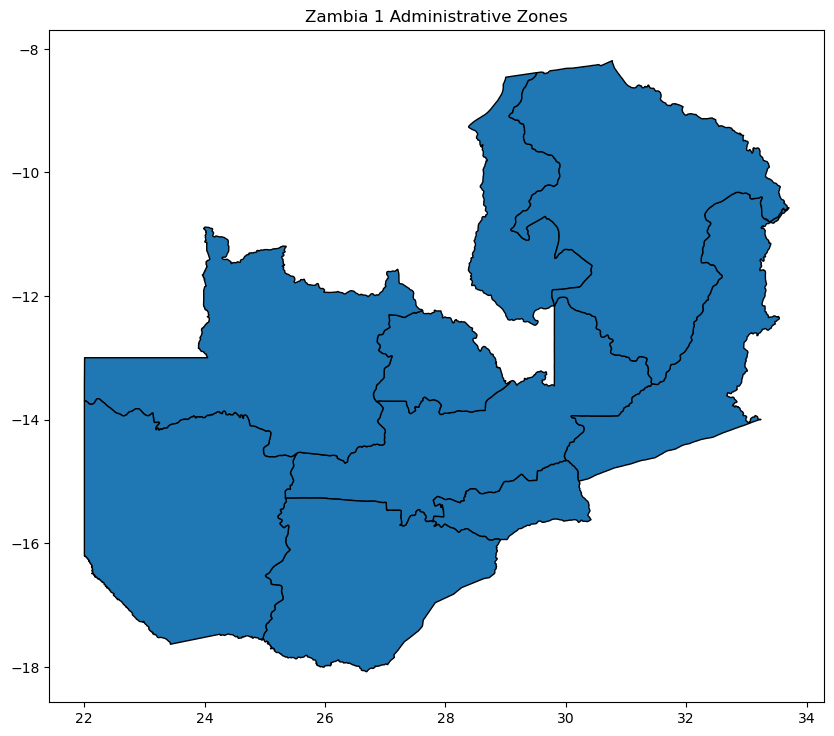

In [7]:
# Plot the shapefile
zambia_gdf_1.plot(figsize=(10, 10), edgecolor='black')
plt.title("Zambia 1 Administrative Zones")
plt.show()


### Administrative 2

In [9]:
zambia_gdf_2, counties_list_level2 = summarize_admin_level("level2", "ADM2_NAME")

Administrative Level2 Units (ADM2_NAME):
['Chibombo', 'Kabwe', 'Kapiri-Mposhi', 'Mkushi', 'Mumbwa', 'Serenje', 'Chililabombwe', 'Chingola', 'Kalulushi', 'Kitwe', 'Luanshya', 'Lufwanyama', 'Masaiti', 'Mpongwe', 'Mufulira', 'Ndola', 'Chadiza', 'Chama', 'Chipata', 'Katete', 'Lundazi', 'Mambwe', 'Nyimba', 'Petauke', 'Chienge', 'Kawambwa', 'Mansa', 'Milenge', 'Mwense', 'Nchelenge', 'Samfya', 'Chongwe', 'Kafue', 'Luangwa', 'Lusaka', 'Kabompo', 'Kasempa', 'Mufumbwe', 'Mwinilunga', 'Solwezi', 'Chilubi', 'Chinsali', 'Isoka', 'Kaputa', 'Kasama', 'Luwingu', 'Mbala', 'Mpika', 'Mporokoso', 'Mpulungu', 'Mungwi', 'Nakonde', 'Choma', 'Gwembe', 'Itezhi-tezhi', 'Kalomo', 'Kazungula', 'Livingstone', 'Mazabuka', 'Monze', 'Namwala', 'Siavonga', 'Sinazongwe', 'Kaoma', 'Mongu', 'Sesheke', 'Chavuma', 'Zambezi', 'Kalabo', 'Lukulu', 'Senanga', "Shang'ombo"] 

Number of unique ADM2_NAME units: 72



In [10]:
zambia_gdf_2.head(10)

,geometry,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,STATUS,STR2_YEAR,Shape_Area,Shape_Leng
0,"POLYGON ((27.1826 -14.54599, 27.18318 -14.5580...",270,Zambia,3426,Central,65174,Chibombo,NO,3000,Member State,1000,1.118330,5.896219
1,"POLYGON ((28.10034 -14.65707, 28.10227 -14.678...",270,Zambia,3426,Central,65175,Kabwe,NO,3000,Member State,1000,0.134045,1.927680
2,"POLYGON ((26.85145 -13.70642, 26.86118 -13.715...",270,Zambia,3426,Central,65176,Kapiri-Mposhi,NO,3000,Member State,1000,1.018897,5.906793
3,"POLYGON ((28.58818 -14.31777, 28.59201 -14.319...",270,Zambia,3426,Central,65177,Mkushi,NO,3000,Member State,1000,1.896196,6.293441
4,"POLYGON ((25.33503 -15.16956, 25.33664 -15.189...",270,Zambia,3426,Central,65178,Mumbwa,NO,3000,Member State,1000,1.828824,8.273817
5,"POLYGON ((29.79389 -13.49255, 29.79611 -13.506...",270,Zambia,3426,Central,65179,Serenje,NO,3000,Member State,1000,1.940231,6.400073
6,"POLYGON ((27.51616 -12.27312, 27.52756 -12.289...",270,Zambia,3427,Copperbelt,65180,Chililabombwe,NO,3000,Member State,1000,0.076861,1.702163
7,"POLYGON ((27.31461 -12.34717, 27.33848 -12.370...",270,Zambia,3427,Copperbelt,65181,Chingola,NO,3000,Member State,1000,0.145245,2.438254
8,"POLYGON ((27.73638 -12.83158, 27.74158 -12.841...",270,Zambia,3427,Copperbelt,65182,Kalulushi,NO,3000,Member State,1000,0.092496,1.633485
9,"POLYGON ((28.11201 -12.78233, 28.11233 -12.794...",270,Zambia,3427,Copperbelt,65183,Kitwe,NO,3000,Member State,1000,0.073343,1.336894


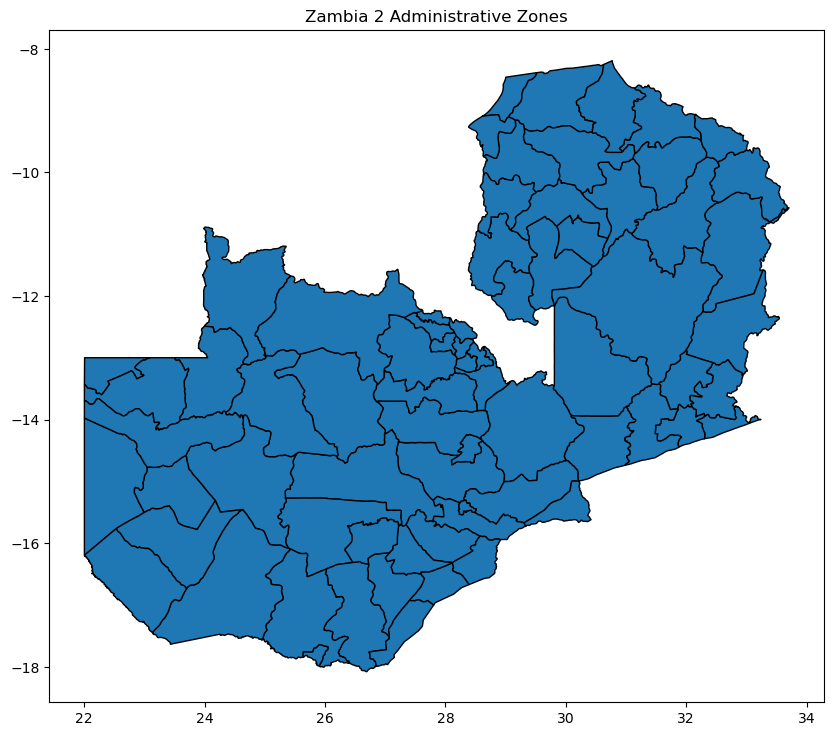

In [11]:
# Plot the shapefile
zambia_gdf_2.plot(figsize=(10, 10), edgecolor='black')
plt.title("Zambia 2 Administrative Zones")
plt.show()


### Administraitve 3 (Camps)

In [12]:
# Load Zambia's third administrative level (camps) from shapefile
shapefile_path = (
    "data/boundaries/Agricultural_blocks_and_camps_062022_Version_01/"
    "Agricultural_blocks_and_camps_062022_Version_01.shp"
)

# Read shapefile into GeoDataFrame
zambia_gdf_3 = gpd.read_file(shapefile_path)

# Preview the first 10 rows
zambia_gdf_3.head(10)

,Fid,Province,District,Block,Camp,Area_Sq_km,Area_ha,Other_ fea,Region,Rainfall,Growth_per,layer,path,geometry
0,1.0,Copperbelt,Mufulira,Murundu,Mokambo,59.0,5870.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((28.24986 -12.4105, 28.25766 -12.4079..."
1,2.0,Copperbelt,Kalulushi,Chati,Chati Central,209.0,20862.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.89969 -12.75352, 27.89859 -12.753..."
2,3.0,Copperbelt,Kalulushi,Chati,Kafubu Depot,244.0,24414.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.89969 -12.75352, 27.89977 -12.753..."
3,4.0,Copperbelt,Lufwanyama,Kafubu,Lumanto,98.0,9795.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.78696 -12.99465, 27.78562 -12.998..."
4,5.0,Copperbelt,Lufwanyama,Kafubu,Chikabuke,84.0,8350.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.72044 -13.00639, 27.72347 -13.006..."
5,6.0,Copperbelt,Lufwanyama,Katembula,Mukutuma,227.0,22652.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.91107 -13.01764, 27.91097 -13.017..."
6,7.0,Copperbelt,Lufwanyama,Kafubu,Lungwa,78.0,7845.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.85856 -12.92856, 27.85892 -12.932..."
7,8.0,Copperbelt,Lufwanyama,Kafubu,Mibenge,32.0,3162.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.86069 -12.9782, 27.85641 -12.9712..."
8,9.0,Copperbelt,Lufwanyama,Bulaya,Kampundu,54.0,5355.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((27.91107 -13.01764, 27.91088 -13.017..."
9,10.0,Copperbelt,Lufwanyama,Mushingashi,Mushingashi,277.0,27666.0,None,III,Above 1000mm,120-150 days,Agric camps,C:\Users\Dell\Documents\National Headquarters\...,"POLYGON ((26.9181 -12.82225, 26.91842 -12.8220..."


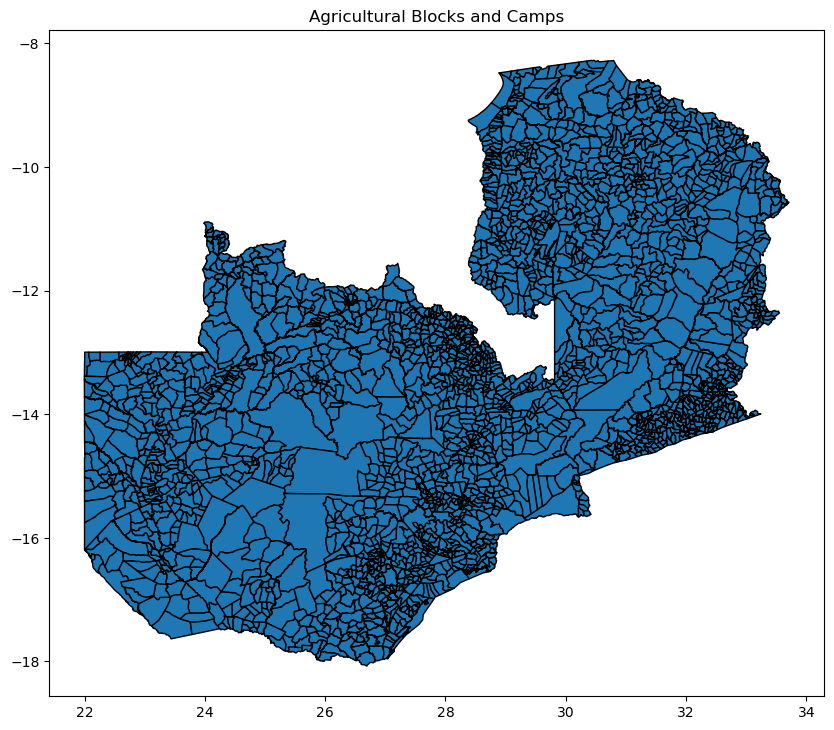

In [13]:
# Plot the shapefile
zambia_gdf_3.plot(figsize=(10, 10), edgecolor='black')
plt.title("Agricultural Blocks and Camps")
plt.show()


### Examining Camp Properties 

Since the camp data is a bit messy, I am going to examine 

In [16]:
# Shape of the camps GeoDataFrame
print(f"Dataset dimensions (rows, columns): {zambia_gdf_3.shape}")

# Number of unique camps
num_unique_camps = zambia_gdf_3["Camp"].nunique()
print(f"Number of unique camps: {num_unique_camps}")

# Count of missing values in the Camp column
num_missing_camps = zambia_gdf_3["Camp"].isna().sum()
print(f"Number of missing camp entries: {num_missing_camps}")


Dataset dimensions (rows, columns): (2648, 14)
Number of unique camps: 2447
Number of missing camp entries: 27


#### Anaylsis

There are 2648 rows, and 2447 unique camps. Furthermore, there are only 27 camp names that are missing. As a result, there are most likely repeat of names. This is examined in the line directly below. 

In [18]:
# Count occurrences of each camp, only show those > 1
print(zambia_gdf_3["Camp"].value_counts().sort_values(ascending=False)[lambda x: x > 1])


Camp
Kawama         6
Chisanga       4
Mushingashi    4
Kazembe        4
Bombwe         3
              ..
Kakoma         2
Kasongole      2
Muyembe        2
Kafubashi      2
Chikowa        2
Name: count, Length: 149, dtype: int64


### Assigning Names for Missing Camps 

Repeated camp names are not problematic for the analysis, but missing values are. To address this, I assign placeholder names (e.g., `Camp_1`, `Camp_2`, …) to all null entries in the `Camp` field. This ensures every record has an identifiable camp name and avoids issues in downstream analysis.  

In [19]:
# Find rows where "Camp" is missing
missing_camp_mask = zambia_gdf_3["Camp"].isna()
num_missing = missing_camp_mask.sum()
print(f"Number of missing camp entries: {num_missing}")

# Generate new names: Camp 1, Camp 2, ...
new_camp_names = [f"Camp_{i+1}" for i in range(num_missing)]

# Assign new names to missing entries
zambia_gdf_3.loc[missing_camp_mask, "Camp"] = new_camp_names

# Confirm number of unique camps after filling
num_unique_camps = zambia_gdf_3["Camp"].nunique()
print(f"Number of unique camps after assignment: {num_unique_camps}")


Number of missing camp entries: 27
Number of unique camps after assignment: 2474


## Loading Seasonal Precipitation 

Now, we can load the seasonal precipitation created in Loading and Preprocessing Pixels

- add link once in GitHub


In [20]:
zambia_seasonal_precip = gpd.read_feather("data/precipitation data/zambia_seasonal_precipitation.feather")
zambia_seasonal_precip.head()

,Pixel_ID,lat,lon,geometry,1982,1983,1984,1985,1986,1987,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),225.556387,467.327110,379.056663,547.837438,466.369424,372.539793,...,459.273431,510.300161,794.782250,834.590998,344.435706,541.610650,586.979768,472.423072,399.798939,309.440754
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),232.672253,477.412403,403.193873,520.408785,462.398110,339.756133,...,446.592047,503.096770,795.379276,826.291929,337.878571,527.980437,581.821075,466.903618,403.448959,314.028983
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),236.313336,498.753280,408.867738,527.346810,493.176775,335.542497,...,454.481295,511.041344,797.369767,849.360176,329.452618,546.530782,565.140982,466.392764,412.349397,313.639112
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),265.484028,547.677701,469.945710,622.998602,526.929316,421.684413,...,523.684460,569.837520,946.763842,924.363547,383.331313,627.133768,676.377123,653.925247,443.855224,321.392947
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),266.120007,548.409480,470.222745,624.421461,525.997389,421.097061,...,531.354685,593.493279,950.089724,925.483686,393.188345,633.070431,679.642501,661.254611,449.883613,326.462010


<Axes: >

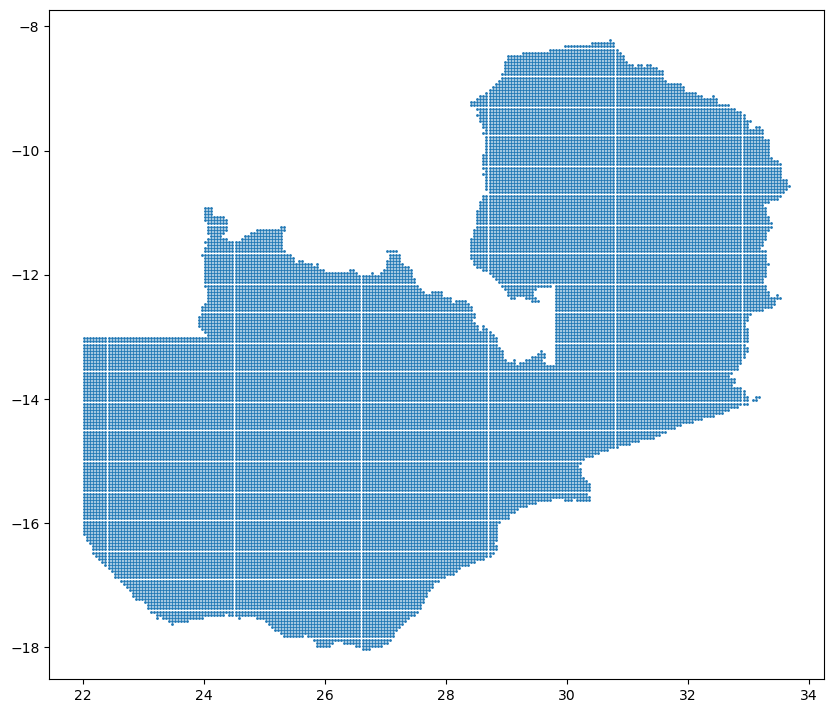

In [21]:
zambia_seasonal_precip.geometry.plot(figsize=(10, 10), markersize=1)

## Assigning Pixels to Boundaries 

In [22]:
'''
Move in script
'''


def spatial_join_by_intersects(precip_gdf, admin_gdf, admin_col='ADM1_NAME', epsg=4326):
    """
    Ensure both GeoDataFrames are in the same CRS and perform a spatial join 
    based on the 'intersects' predicate. Drops the 'index_right' column after joining.

    Parameters:
    - precip_gdf (GeoDataFrame): GeoDataFrame with point or polygon data (e.g., precipitation data).
    - admin_gdf (GeoDataFrame): GeoDataFrame with administrative boundaries.
    - admin_col (str): The column name in admin_gdf to keep in the join.
    - epsg (int): The EPSG code for the target CRS (default is 4326).

    Returns:
    - GeoDataFrame: Result of the spatial join with the admin column attached, excluding 'index_right'.
    """
    precip_gdf = precip_gdf.to_crs(epsg=epsg)
    admin_gdf = admin_gdf.to_crs(epsg=epsg)

    # Filter invalid geometries (optional but recommended)
    precip_gdf = precip_gdf[precip_gdf.is_valid]
    admin_gdf = admin_gdf[admin_gdf.is_valid]

    joined = gpd.sjoin(
        precip_gdf,
        admin_gdf[[admin_col, 'geometry']],
        how='left',
        predicate='intersects'
    )

    if 'index_right' in joined.columns:
        joined = joined.drop(columns='index_right')

    return joined


### Administrative 1

In [24]:
zambia_seasonal_precip_1 = spatial_join_by_intersects(zambia_seasonal_precip, zambia_gdf_1)
zambia_seasonal_precip_1.head(10)

,Pixel_ID,lat,lon,geometry,1982,1983,1984,1985,1986,1987,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,ADM1_NAME
0,Pixel 1,-18.024985,26.624978,POINT (26.62498 -18.02499),225.556387,467.327110,379.056663,547.837438,466.369424,372.539793,...,510.300161,794.782250,834.590998,344.435706,541.610650,586.979768,472.423072,399.798939,309.440754,Southern
11111,Pixel 2,-18.024985,26.674978,POINT (26.67498 -18.02499),232.672253,477.412403,403.193873,520.408785,462.398110,339.756133,...,503.096770,795.379276,826.291929,337.878571,527.980437,581.821075,466.903618,403.448959,314.028983,Southern
17314,Pixel 3,-18.024985,26.724978,POINT (26.72498 -18.02499),236.313336,498.753280,408.867738,527.346810,493.176775,335.542497,...,511.041344,797.369767,849.360176,329.452618,546.530782,565.140982,466.392764,412.349397,313.639112,Southern
18425,Pixel 4,-17.974985,25.874979,POINT (25.87498 -17.97499),265.484028,547.677701,469.945710,622.998602,526.929316,421.684413,...,569.837520,946.763842,924.363547,383.331313,627.133768,676.377123,653.925247,443.855224,321.392947,Southern
19536,Pixel 5,-17.974985,25.924979,POINT (25.92498 -17.97499),266.120007,548.409480,470.222745,624.421461,525.997389,421.097061,...,593.493279,950.089724,925.483686,393.188345,633.070431,679.642501,661.254611,449.883613,326.462010,Southern
20647,Pixel 6,-17.974985,25.974979,POINT (25.97498 -17.97499),270.841604,576.744131,464.341511,609.824749,566.104045,399.019460,...,603.808784,962.545109,922.771164,389.028405,634.385965,679.233486,665.053145,455.335965,327.364719,Southern
21758,Pixel 7,-17.974985,26.024979,POINT (26.02498 -17.97499),267.786691,546.157323,442.743401,619.696249,554.692422,413.768380,...,591.573272,937.057711,904.171169,375.743341,639.621434,677.561323,656.661766,457.301686,326.952674,Southern
22869,Pixel 8,-17.974985,26.074979,POINT (26.07498 -17.97499),264.979501,537.094821,434.540909,610.965087,538.962724,403.286435,...,582.919848,938.380774,894.011900,370.812503,633.062112,686.458623,652.733169,456.263660,325.626959,Southern
23980,Pixel 9,-17.974985,26.524978,POINT (26.52498 -17.97499),243.221125,498.988043,378.512442,559.515865,470.817978,396.103834,...,525.132696,848.637653,863.357555,362.581014,584.635025,638.748784,520.959432,422.369267,303.149464,Southern
1,Pixel 10,-17.974985,26.574978,POINT (26.57498 -17.97499),242.096573,480.379058,386.646572,564.819007,478.063760,384.807493,...,517.665652,827.441684,854.642918,358.609797,569.652804,630.383546,492.961326,421.173559,301.795856,Southern


In [25]:
# Count the number of missing (NaN) values in the 'Camp' column
zambia_seasonal_precip_1['ADM1_NAME'].isna().sum()

0

### Administrative 2

In [ ]:
zambia_seasonal_precip_2 = spatial_join_by_intersects(zambia_seasonal_precip, zambia_gdf_2, admin_col="ADM2_NAME")
zambia_seasonal_precip_2

In [ ]:
# Count the number of missing (NaN) values in the 'Camp' column
zambia_seasonal_precip_2['ADM2_NAME'].isna().sum()

### Administrative 3

In [ ]:
zambia_seasonal_precip_3 = spatial_join_by_intersects(zambia_seasonal_precip, zambia_gdf_3, admin_col="Camp")
zambia_seasonal_precip_3

In [ ]:
# Count the number of missing (NaN) values in the 'Camp' column
zambia_seasonal_precip_3['Camp'].isna().sum()

### Mapping Missing Pixel Values 

In [ ]:
# Filter rows where Camp is missing
missing_camp = zambia_seasonal_precip_3[zambia_seasonal_precip_3['Camp'].isna()]

# Ensure both GeoDataFrames are in the same CRS
missing_camp = missing_camp.to_crs(epsg=4326)
zambia_gdf_3 = zambia_gdf_3.to_crs(epsg=4326)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
zambia_gdf_3.boundary.plot(ax=ax, color='black', linewidth=1)
missing_camp.plot(ax=ax, color='red', markersize=10, label='Missing Camp')

# Optional: Add legend and title
ax.set_title("Zambia: Locations with Missing 'Camp'", fontsize=14)
ax.legend()
plt.show()

### Temporary Solution

Simliar to dropping camps, I will drop pixels with `NA` in `Camp`.

In [ ]:
zambia_seasonal_precip_3 = zambia_seasonal_precip_3.dropna(subset=["Camp"])
zambia_seasonal_precip_3.shape

## Additional Preprocessing

The end goal is caluclate the payout balance metric. However, we must do some additional preprocessing. 

### Converting Pivoting Data to Long

- Add description

#### Administrative 1

In [ ]:
zambia_long_gdf_1 = long_format_precipitation(zambia_seasonal_precip_1, cluster_columns=["ADM1_NAME"])
zambia_long_gdf_1.head(10)

#### Administrative 2

In [ ]:
zambia_long_gdf_2 = long_format_precipitation(zambia_seasonal_precip_2, cluster_columns=["ADM2_NAME"])
zambia_long_gdf_2.head(10)

#### Administrative 3

In [ ]:
zambia_long_gdf_3 = long_format_precipitation(zambia_seasonal_precip_3, cluster_columns=["Camp"])
zambia_long_gdf_3.head(10)

### Spatial Aggregation to Administrative District

- Spatial Aggregation is the mean of all pixels

In [ ]:
'''
Move to script
'''

def compute_mean_precip(df, group_cols, value_col="precipitation"):
    """
    Groups the DataFrame by specified columns and computes the mean of the value column.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - group_cols (list): List of columns to group by.
    - value_col (str): Name of the column to average.

    Returns:
    - DataFrame with group means.
    """
    return df.groupby(group_cols)[value_col].mean().reset_index()

#### Administrative 1

In [ ]:
mean_precip_by_admin_1_season = compute_mean_precip(zambia_long_gdf_1, ["ADM1_NAME", "agricultural_season"])
mean_precip_by_admin_1_season.head(10)

#### Administrative 2

In [ ]:
mean_precip_by_admin_2_season = compute_mean_precip(zambia_long_gdf_2, ["ADM2_NAME", "agricultural_season"])
mean_precip_by_admin_2_season.head(10)

#### Administrative 3

In [ ]:
mean_precip_by_admin_3_season = compute_mean_precip(zambia_long_gdf_3, ["Camp", "agricultural_season"])
mean_precip_by_admin_3_season.head(10)

### Drought Indicator

Now, we will add in the drought indicator. I check the number of unique drought years, which should be 9. 

#### Administrative 1

In [ ]:
mean_precip_by_admin_1_season = assign_drought_indicator(mean_precip_by_admin_1_season, "ADM1_NAME")
mean_precip_by_admin_1_season.head(10)

In [ ]:
'''
Move to script
'''

def count_unique_drought_years(df, admin_col="ADM1_NAME"):
    """
    Counts the number of drought years per administrative region and returns
    the number of unique drought year counts.

    Parameters:
    - df (DataFrame): Input DataFrame that includes 'drought_indicator'.
    - admin_col (str): Column name for the administrative unit to group by.

    Returns:
    - ndarray: Unique drought year counts across the regions.
    """
    drought_counts = (
        df[df["drought_indicator"] == 1]
        .groupby(admin_col)["drought_indicator"]
        .count()
        .reset_index(name="drought_years")
    )

    return print(drought_counts["drought_years"].unique())

In [ ]:
count_unique_drought_years(mean_precip_by_admin_1_season, admin_col="ADM1_NAME")

#### Administrative 2

In [ ]:
mean_precip_by_admin_2_season = assign_drought_indicator(mean_precip_by_admin_2_season, "ADM2_NAME")
mean_precip_by_admin_2_season.head(10)

In [ ]:
count_unique_drought_years(mean_precip_by_admin_2_season, admin_col="ADM2_NAME")

#### Administrative 3

In [ ]:
mean_precip_by_admin_3_season = assign_drought_indicator(mean_precip_by_admin_3_season, "Camp")
mean_precip_by_admin_3_season.head(10)

In [ ]:
count_unique_drought_years(mean_precip_by_admin_3_season, admin_col="Camp")

### Drought Heatmaps

#### Administrative 1

In [ ]:
plot_drought_heatmap(mean_precip_by_admin_1_season, "ADM1_NAME")

#### Administrative 2

In [ ]:
plot_drought_heatmap(mean_precip_by_admin_2_season, "ADM2_NAME")

#### Administrative 3

Please zoom in for better readiability 

In [ ]:
plot_drought_heatmap(mean_precip_by_admin_3_season, "Camp")

## Within-Cluster (Administrative District) Drought Variation

To better understand drought distribution within each administrative district, I will analyze the number of pixels experiencing drought in each zone. This will help determine whether drought affects the entire district or only specific areas, inidicating potential basis risk.

### Steps:

1. **Create an agricultural season variable** to align all data with the relevant growing season.  
2. **Aggregate pixel-level data** to the agricultural season for consistency in analysis.  
3. **Assign a drought indicator to each pixel** based on whether it falls within the lowest 20% of rainfall seasons.  
4. **Calculate the drought percentage** for each administrative district in each season:  

$$
\text{Drought Percentage} = \left( \frac{\text{Number of Pixels in Drought}}{\text{Total Pixels in District}} \right) \times 100
$$

This approach will reveal spatial drought variations within each district, providing insights into localized drought intensity and improving climate risk assessment


In [ ]:
seasonal_precip_pixel_1 = zambia_long_gdf_1.copy() 

seasonal_precip_pixel_2 = zambia_long_gdf_2.copy() 

seasonal_precip_pixel_3 = zambia_long_gdf_3.copy() 

### Drought Indicator for each Pixel

Now, we will add a drougth indicator for each pixel rather than district. This will allow us to calculate the percentage of pixels experiencing a drought in each district or camp.

#### Administrative 1


In [ ]:
seasonal_precip_pixel_1 = assign_drought_indicator(seasonal_precip_pixel_1, "Pixel_ID")
seasonal_precip_pixel_1.head(10)

#### Administrative 2

In [ ]:
seasonal_precip_pixel_2 = assign_drought_indicator(seasonal_precip_pixel_2, "Pixel_ID")
seasonal_precip_pixel_2.head(10)

#### Administrative 3

In [ ]:
seasonal_precip_pixel_3 = assign_drought_indicator(seasonal_precip_pixel_3, "Pixel_ID")
seasonal_precip_pixel_3.head(10)

###  Calculating Percent of Pixels Experiencing Drought in each Administrative District or Camp


#### Administrative 1


In [ ]:
from utils.drought_payout_anlaysis import summarize_drought_by_cluster

In [ ]:
seasonal_precip_pixel_1 = summarize_drought_by_cluster(seasonal_precip_pixel_1, "ADM1_NAME")
seasonal_precip_pixel_1

#### Administrative 2

In [ ]:
seasonal_precip_pixel_2 = summarize_drought_by_cluster(seasonal_precip_pixel_2, "ADM2_NAME")
seasonal_precip_pixel_2

#### Administrative 3

In [ ]:
seasonal_precip_pixel_3 = summarize_drought_by_cluster(seasonal_precip_pixel_3, "Camp")
seasonal_precip_pixel_3

### Plotting Drought Percentage by District or Camp

In [ ]:
plot_drought_percentage_heatmap(seasonal_precip_pixel_1, "ADM1_NAME")

In [ ]:
plot_drought_percentage_heatmap(seasonal_precip_pixel_2, "ADM2_NAME")

In [ ]:
plot_drought_percentage_heatmap(seasonal_precip_pixel_3, "Camp")

## Payout Balance Metric

To evaluate how well the clustering minimizes **basis risk**, we first compute the **absolute deviation** from a 50% payout rate for each cluster-year pair:

$$
D_t^k = |P_t^k - 50|
$$

Where:

- $P_t^k$ = Percentage of pixels receiving a payout in **cluster** $k$ during **year** $t$  
- $D_t^k$ = Absolute deviation from the 50% balance point — **higher values indicate greater basis risk**

---

### Payout Balance Index (PBI)

We then transform this deviation into a **Payout Balance Index (PBI)** scaled between 0 and 100:

$$
\text{PBI}_{t,k} = \left(1 - \frac{D_t^k}{50} \right) \times 100
$$

- A value of **100** means perfect balance: all or none of the farmers in the cluster received payouts  
- A value of **0** indicates a 50/50 split — the **worst-case scenario** for basis risk

---

### Overall Clustering Quality

To assess clustering quality across the entire dataset, we compute the **average PBI**:

$$
\text{PBI}_{\text{avg}} = \frac{1}{N} \sum_{t,k} \text{PBI}_{t,k}
$$

Where $N$ is the total number of (year × cluster) combinations.

---

### Basis Risk Interpretation

- A **PBI close to 100** reflects **low basis risk**: clusters are internally consistent — farmers in the same area experience similar insurance outcomes  
- A **PBI near 0** reflects **high basis risk**: payout decisions vary significantly within clusters, indicating poor targeting

This index provides a **clear, interpretable, and policy-relevant** measure of how well your spatial clustering aligns with actual drought impact.


In [ ]:
from utils.drought_payout_anlaysis import compute_payout_balance_index

#### Administrative 1


In [ ]:
seasonal_precip_pixel_1 = compute_payout_balance_index(seasonal_precip_pixel_1)

payout_score_admin_1 = seasonal_precip_pixel_1["payout_balance_index"].mean()
print(f"Payout Balance Score Administratvie 1 Zones: {payout_score_admin_1:.2f}")

#### Administrative 2


In [ ]:
seasonal_precip_pixel_2 = compute_payout_balance_index(seasonal_precip_pixel_2)

payout_score_admin_2 = seasonal_precip_pixel_2["payout_balance_index"].mean()
print(f"Payout Balance Score Administratvie 2 Zones: {payout_score_admin_2:.2f}")

#### Administrative 3

In [ ]:
seasonal_precip_pixel_3 = compute_payout_balance_index(seasonal_precip_pixel_3)

payout_score_admin_3 = seasonal_precip_pixel_3["payout_balance_index"].mean()
print(f"Payout Balance Score Camps: {payout_score_admin_3:.2f}")

## Forgone Payouts

- For Admin 1 and Admin 2, there are 25091 pixels, and for Admin 3 (camps), there are 25054 pixels 

- Assumes each pixel represents an individual farmer and everyone is equally distributed geographically 

- The formula is $(\text{Value of the Payout})(\text{Percent of Basis Risk, which 1-PBI})(\text{Number of Farmers, or Number of Pixels Per Zone})$

- Lets assume the value is around 1600 kwacha ($\approx$ \$68. This is calcualted by taking the payout value 800 million kwacha and dividng it by the 500,071 smallholder farmers [who received a payment due to climate related losses](https://www.pula-advisors.com/post/zambia-s-largest-crop-index-insurance-payout-marks-historic-milestone-for-smallholder-farmers).



In [ ]:
payout_value = 1600

admin_1_pixels = 25091

admin_2_pixels = 25091

admin_3_pixels = 25054

### Administrative 1

In [ ]:
# Administrative 1 forgone payments
admin_1_fp = (payout_value) * (1 - (payout_score_admin_1/100)) * (admin_1_pixels) 
print(f"Administrative 1 forgone payments: {admin_1_fp:.2f} kwacha")

### Administrative 2

In [ ]:
# Administrative 2 forgone payments
admin_2_fp = (payout_value) * (1 - (payout_score_admin_2/100)) * (admin_2_pixels) 
print(f"Administrative 2 forgone payments: {admin_2_fp:.2f} kwacha")

### Administrative 3

In [ ]:
# Administrative 3 forgone payments
admin_3_fp = (payout_value) * (1 - (payout_score_admin_2/100)) * (admin_3_pixels) 
print(f"Administrative 3 forgone payments: {admin_3_fp:.2f} kwacha")

## Plot

In [ ]:
# Example data
payout_scores = [payout_score_admin_1, payout_score_admin_2, payout_score_admin_3]
forgone_payments = [admin_1_fp, admin_2_fp, admin_3_fp]

plt.figure(figsize=(8, 5))
plt.plot(payout_scores, forgone_payments, marker='o', linestyle='-', color='b')

plt.xlabel("Payout Score (%)")
plt.ylabel("Forgone Payments (Million ZMW)")
plt.title("Forgone Payments vs Payout Scores by Admin Level")

# Custom offsets & alignment for each point
offsets = [(35, -5), (-60, 5), (15, 7)]  # (x_offset, y_offset) in points
alignments = [("center", "bottom"), ("left", "top"), ("right", "bottom")]

for (x, y), (dx, dy), (ha, va) in zip(
    zip(payout_scores, forgone_payments), offsets, alignments
):
    plt.annotate(
        f"{y/1e6:.2f} ZMW",   # divide by 1e6
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha, va=va,
        fontsize=10, color="black"
    )

plt.grid(True, linestyle="--", alpha=0.7)
plt.show()